In [37]:
import sys
import os

# Add parent directory to path so we can import src
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import json
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.legacy import Adam

from src.data_loader import load_train_val_test
from src.model_builder import build_emotion_model

In [38]:
from pathlib import Path
import os

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "notebooks" / "data"

print("Resolved DATA_DIR:", DATA_DIR)
print("Exists:", DATA_DIR.exists())
print("X exists:", (DATA_DIR / "X.npy").exists())
print("y exists:", (DATA_DIR / "y.npy").exists())



Resolved DATA_DIR: /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/data
Exists: True
X exists: True
y exists: True


In [39]:
X_train, X_val, X_test, y_train, y_val, y_test, labels = load_train_val_test(
    X_path=DATA_DIR / "X.npy",
    y_path=DATA_DIR / "y.npy"
)
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)
print("Test data shape:", X_test.shape, y_test.shape)
print("Labels:", labels)
print("Number of classes:", len(labels))
num_classes = len(labels)


Training data shape: (1946, 128, 128, 2) (1946, 8)
Validation data shape: (417, 128, 128, 2) (417, 8)
Test data shape: (418, 128, 128, 2) (418, 8)
Labels: ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
Number of classes: 8


In [40]:
print("y_val type:", type(y_val))
print("y_val shape:", y_val.shape)
print("y_val min/max:", y_val.min(), y_val.max())


y_val type: <class 'numpy.ndarray'>
y_val shape: (417, 8)
y_val min/max: 0.0 1.0


In [41]:
import tensorflow as tf

def add_noise(x, noise_std=0.02):
    noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=noise_std)
    return x + noise


In [42]:
def specaugment(x, time_mask_pct=0.05, freq_mask_pct=0.05):
    # x: (128,128,2)
    h = tf.shape(x)[0]  # 128
    w = tf.shape(x)[1]  # 128

    # Frequency mask (mask some mel bins)
    f = tf.cast(tf.cast(h, tf.float32) * freq_mask_pct, tf.int32)
    f0 = tf.random.uniform([], 0, h - f + 1, dtype=tf.int32)
    freq_mask = tf.concat([
        tf.ones((f0, w, 2)),
        tf.zeros((f, w, 2)),
        tf.ones((h - f0 - f, w, 2))
    ], axis=0)

    # Time mask (mask some frames)
    t = tf.cast(tf.cast(w, tf.float32) * time_mask_pct, tf.int32)
    t0 = tf.random.uniform([], 0, w - t + 1, dtype=tf.int32)
    time_mask = tf.concat([
        tf.ones((h, t0, 2)),
        tf.zeros((h, t, 2)),
        tf.ones((h, w - t0 - t, 2))
    ], axis=1)

    return x * freq_mask * time_mask


In [43]:
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000)

train_ds = train_ds.map(lambda x, y: (add_noise(x, 0.02), y),
                        num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (specaugment(x, 0.05, 0.05), y),
                        num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)


In [44]:
model = build_emotion_model()

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-4)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "cnn_bilstm_emotion"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 2)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 128, 128, 32)      576       
                                                                 
 batch_normalization_12 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 64, 64, 32) 

In [56]:

RUN_DIR = Path("notebooks/models") / datetime.now().strftime("run_%Y-%m-%d_%H-%M-%S")
RUN_DIR.mkdir(parents=True, exist_ok=True)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(RUN_DIR, "best_model.h5"),
        monitor="val_accuracy",
        save_best_only=True
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=12,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        patience=3,
        factor=0.5
    )
]

In [46]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=callbacks
)

Epoch 1/60
61/61 [==============================] - 18s 249ms/step - loss: 2.2232 - accuracy: 0.1984 - val_loss: 2.0136 - val_accuracy: 0.1559 - lr: 5.0000e-04
Epoch 2/60


/opt/anaconda3/envs/emotion-env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


61/61 [==============================] - 15s 251ms/step - loss: 1.9873 - accuracy: 0.2549 - val_loss: 2.0045 - val_accuracy: 0.2398 - lr: 5.0000e-04
Epoch 3/60
61/61 [==============================] - 16s 256ms/step - loss: 1.8948 - accuracy: 0.2878 - val_loss: 2.0027 - val_accuracy: 0.2326 - lr: 5.0000e-04
Epoch 4/60
61/61 [==============================] - 15s 241ms/step - loss: 1.8895 - accuracy: 0.2929 - val_loss: 1.8738 - val_accuracy: 0.2446 - lr: 5.0000e-04
Epoch 5/60
61/61 [==============================] - 14s 228ms/step - loss: 1.8165 - accuracy: 0.2965 - val_loss: 1.7946 - val_accuracy: 0.3141 - lr: 5.0000e-04
Epoch 6/60
61/61 [==============================] - 13s 211ms/step - loss: 1.7605 - accuracy: 0.3232 - val_loss: 1.7068 - val_accuracy: 0.3285 - lr: 5.0000e-04
Epoch 7/60
61/61 [==============================] - 14s 233ms/step - loss: 1.7686 - accuracy: 0.3330 - val_loss: 1.5140 - val_accuracy: 0.4293 - lr: 5.0000e-04
Epoch 8/60
61/61 [==============================] -

In [59]:
from pathlib import Path
from datetime import datetime

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "notebooks" / "data"
MODELS_DIR = PROJECT_ROOT / "notebooks" / "models"

run_name = f"run_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
RUN_DIR = MODELS_DIR / run_name
RUN_DIR.mkdir(parents=True, exist_ok=True)

# Save artifacts
model.save(RUN_DIR / "final_model.h5")


In [60]:
print("Run directory:", RUN_DIR)
print("Files saved:", list(RUN_DIR.iterdir()))


Run directory: /Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-13_06-32-58
Files saved: [PosixPath('/Users/malakmaher/Documents/GitHub/Emotion-Recognition/notebooks/models/run_2025-12-13_06-32-58/final_model.h5')]


In [61]:
history_clean = {
    k: [float(v) for v in vals]
    for k, vals in history.history.items()
}

with open(RUN_DIR / "history.json", "w") as f:
    json.dump(history_clean, f, indent=2)


In [62]:
X_path = DATA_DIR / "X.npy"
X_full = np.load(X_path)

stats = {
    "mean": float(X_full.mean()),
    "std": float(X_full.std())
}

with open(RUN_DIR / "mean_std.json", "w") as f:
    json.dump(stats, f, indent=2)


In [63]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)
with open(os.path.join(RUN_DIR, "evaluation.txt"), "w") as f:
    f.write(f"Test accuracy: {test_acc}\n")


14/14 [==============================] - 1s 46ms/step - loss: 0.7038 - accuracy: 0.7488
Test accuracy: 0.7488038539886475


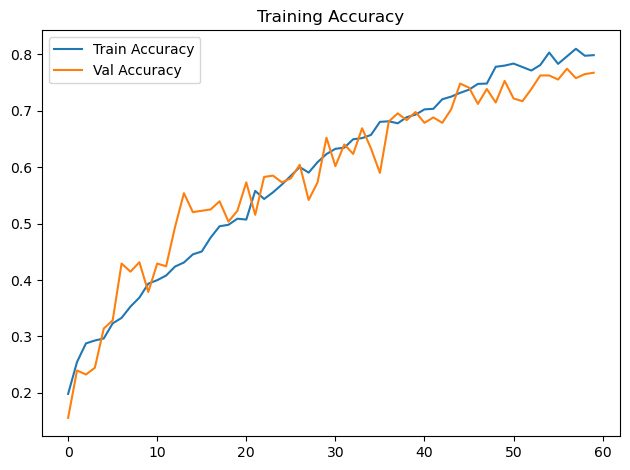

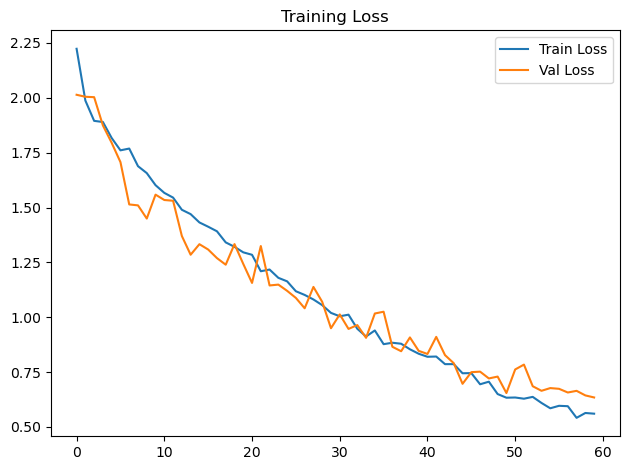

In [64]:
import json
import matplotlib.pyplot as plt

history_path = RUN_DIR / "history.json"
with open(history_path) as f:
    hist = json.load(f)

# Accuracy
fig, ax = plt.subplots()
ax.plot(hist["accuracy"], label="Train Accuracy")
ax.plot(hist["val_accuracy"], label="Val Accuracy")
ax.set_title("Training Accuracy")
ax.legend()
fig.tight_layout()
fig.savefig(RUN_DIR / "accuracy_curve.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)

# Loss
fig, ax = plt.subplots()
ax.plot(hist["loss"], label="Train Loss")
ax.plot(hist["val_loss"], label="Val Loss")
ax.set_title("Training Loss")
ax.legend()
fig.tight_layout()
fig.savefig(RUN_DIR / "loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close(fig)
